# PanDelos-frags and Roary comparison in metagenomics


In [5]:
# import necessary packages
import os
import numpy as np
import re
import pandas as pd 
import pyranges as pr
import re 
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns 
from matplotlib.colors import ListedColormap

# graphical parameters
plt.rcParams['figure.figsize'] = [6.0, 4.0]
plt.rcParams['figure.dpi'] = 300

species = 'abiotrophia_defectiva' #bacteroides_nordii pseudomonas_aeruginosa
pretty_species = '$\it{'+species.split('_')[0].capitalize()+'\ '+species.split('_')[1]+'}$'

# set directories
basedir = os.getcwd()
delosdir = basedir+'/'+species+'/PanDelos'
roarydir = basedir+'/'+species+'/Roary'
prokkadir=basedir+'/'+species+'/Prokka'
figdir = basedir+'/paper_figures'
comparisondir = basedir+'/'+species+'/Comparison/'
os.makedirs(comparisondir,exist_ok=True)
GF_dir = comparisondir+'/GFs'
fasta_directory=GF_dir+'/fasta'
diamond_directory=GF_dir+'/diamond/'
os.makedirs(GF_dir,exist_ok=True)
os.makedirs(fasta_directory,exist_ok=True) 
os.makedirs(diamond_directory,exist_ok=True) 

### Create a dataframe mapping the genome name between original genomes, PanDelos, and Roary

In [6]:
genome_names = os.listdir(delosdir+'/output/fragmented')
matchfile='predictedCDSs_filtered_only_genes.bed'
dict_list_names = []

# read roary file to associate roary aliases to genome names
with open(roarydir+'/output/gene_presence_absence.csv') as f:
    lines = f.readlines()[0:2]
    colnames = lines[0]
    aliases = lines[1]
    
    colnames = colnames.split(',')
    indexes_prokka = [i for i,name in enumerate(colnames) if re.search("prokka", name)]
    colnames = np.array(colnames)[indexes_prokka]
    aliases = np.array(aliases.split(','))[indexes_prokka]
    aliases = [a.split('_')[0] for a in aliases]
    
    names_to_aliases_roary = {colnames[i].strip().strip('\"'):aliases[i].strip().strip('\"') for i,v in enumerate(colnames)}

# read pandelos file to associate pandelos aliases to genome name
for g in genome_names:
    files = os.listdir(delosdir+'/output/fragmented/' + g + '/artifacts')
    afile = [f for f in files if f.endswith(matchfile)][0]
    with open(delosdir+'/output/fragmented/' + g + '/artifacts/' +afile) as f:
        delos_name = f.readline().split('\t')[0]
        
    dict_row = {'genome':g, 'pandelos_name':delos_name, 'roary_name': names_to_aliases_roary['prokka_'+g]}
    dict_list_names.append(dict_row)

# add also complete genomes
ref_genome =  os.listdir(delosdir+"/output/complete")
ref_genome_m = [not r.endswith('.fai') for r in ref_genome]
ref_genome = np.array(ref_genome)[ref_genome_m][0]
print(ref_genome)
ref_delos=delos_name.split('reconstructed')[0]

ref = {'genome': ref_genome, 'pandelos_name':ref_delos, 'roary_name':names_to_aliases_roary['prokka_'+ref_genome]}
dict_list_names.append(ref)
names_df=pd.DataFrame(dict_list_names)
names_df

GCF_013267415.1_ASM1326741v1_genomic.fna


,genome,pandelos_name,roary_name
0,HMP_2012__SRS011310__bin.11.fa,NZ_CP053988.1reconstructed_IBmNh,ILOPGLEA
1,HMP_2012__SRS056892__bin.12.fa,NZ_CP053988.1reconstructed_J8kDg,EGFOGDEI
2,HMP_2012__SRS051941__bin.14.fa,NZ_CP053988.1reconstructed_h5w8O,FJAPHHBF
3,HMP_2012__SRS019073__bin.4.fa,NZ_CP053988.1reconstructed_KmUpV,GKABGAOF
4,HMP_2012__SRS018573__bin.43.fa,NZ_CP053988.1reconstructed_X6Wtj,GCNIEDOA
5,HMP_2012__SRS019591__bin.15.fa,NZ_CP053988.1reconstructed_lNvbo,EHKKLKPA
6,CM_periimplantitis__SP_602SPI_T016__bin.1.fa,NZ_CP053988.1reconstructed_rwPu8,OCEOODIC
7,CM_cf__CF_FIFC013SS_t5M16__bin.10.fa,NZ_CP053988.1reconstructed_rXiFg,CLLHJDKB
8,HMP_2012__SRS018665__bin.11.fa,NZ_CP053988.1reconstructed_6wOTZ,JAODIBLH
9,HMP_2012__SRS064449__bin.25.fa,NZ_CP053988.1reconstructed_P7zAL,LEBPGLFE


## Read in GFs
### PanDelos-frags

In [7]:
ref_to_genes_delos = dict() # #used for looking at the distribution of GF size, based on their gene in the  reference genome
gf_sizes_delos = dict() #used for looking at the distribution of GF size, regardless of their association to a common gene in the reference genome

# PanDelos-frags
with open(delosdir+"/output/output.clus") as f:
        lines = f.readlines()

for l in lines:
    reference=False
    l = l.rstrip()
    l = l.split(' ')
    genome_set = set()
    selected_genes = []
    for gene in l:
        genome = gene.split(':')[0]

        if not re.search("reconstructed", gene): # a gene is not reconstructed, hence is ref
            reference = gene
     
        if genome in genome_set:
            continue
        else:
            genome_set.add(genome)
            selected_genes.append(gene)

    if reference != False:      
        ref_to_genes_delos[reference]= selected_genes #others
    
    if len(genome_set) in gf_sizes_delos.keys():
        gf_sizes_delos[len(genome_set)] += 1
    else:
        gf_sizes_delos[len(genome_set)] = 1

# Make pyranges compatible
dict_list=[]
 
for k in ref_to_genes_delos.keys(): 
    coords = k.split(':')[1]
    start = coords.split('-')[0]
    stop = '-'.join(coords.split('-')[1:3])
    strand = stop[len(stop)-2]
    stop = stop[:len(stop)-3] 
    dict_row = {'Chromosome':1,'Start':start,'End':stop,'Strand':strand, 'ID':k, 'Family':list(set(ref_to_genes_delos[k])), 'Family_size':len(list(set(ref_to_genes_delos[k])))}
    dict_list.append(dict_row)
pandelos_df=pd.DataFrame(dict_list) 

In [8]:
#pd.DataFrame.from_dict(gf_sizes_delos,orient='index').to_csv(delosdir+'/count.csv')

### Roary

In [9]:
# Roary
roary_pres_abs = pd.read_csv(roarydir+'/output/gene_presence_absence.csv',na_filter=False)
gf_sizes_roary = Counter(roary_pres_abs['No. isolates'])

reference_df_roary=roary_pres_abs[roary_pres_abs['prokka_'+ref_genome]!='']
ref_to_genes_roary = dict()
ref_to_len_roary = dict()
for i in reference_df_roary.index:
    ref = reference_df_roary.loc[i,'prokka_'+ref_genome]
    fam = list(reference_df_roary.loc[i,reference_df_roary.columns.isin('prokka_'+names_df['genome'][:-1])].values)
    fam = [f.split('\t')[0] for f in fam if f!= ''] 
    fam.append(ref)
    len_fam = len(fam)
    ref_to_genes_roary[ref]=fam
    ref_to_len_roary[ref]=len_fam

ref_to_genes_roary_df = pd.DataFrame(ref_to_genes_roary.items(), columns=['ID', 'Family'])
ref_to_genes_roary_df = pd.merge(ref_to_genes_roary_df,pd.DataFrame(ref_to_len_roary.items(), columns=['ID', 'Family_size']), on='ID')
reference_df_roary = pd.merge(reference_df_roary.loc[:,['Gene','prokka_'+ref_genome]],ref_to_genes_roary_df, left_on='prokka_'+ref_genome, right_on='ID')

## Import GFF to obtain coordinates of all ref genes + gene name + IDs
gff_file = prokkadir+'/prokka_gffs/prokka_'+ref_genome+'.gff'
dict_list = [] 

with open(gff_file) as f:
    lines = f.readlines()
    for l in lines:
        if l.startswith('##FASTA'):
            break
        elif l.startswith('#'):
            continue
            
        l = l.split('\t')  
        start = int(l[3]) # #nb gtf starts indexing at 1
        stop = l[4]
        others = l[8]
        strand = l[6]
        others = others.split(';')
        ID = others[0].split('=')[1] 

        dict_row = {'Chromosome':1,'Start':start,'End':stop,'Strand':strand,'ID':ID} 
        dict_list.append(dict_row)
roary_gff_df=pd.DataFrame(dict_list)  

roary_gff_df=pd.merge(roary_gff_df,reference_df_roary, left_on="ID",right_on='ID')
roary_df=roary_gff_df.loc[:,['Chromosome','Start','End','Strand','ID','Gene','Family','Family_size']]

In [10]:
df = pd.DataFrame.from_dict(gf_sizes_delos,orient='index')
df_r = pd.DataFrame.from_dict(gf_sizes_roary,orient='index')

df_both = pd.merge(df, df_r, left_index=True, right_index=True)
df_both.columns = ['PanDelos-frags','Roary']
df_both = df_both.sort_index()

tot_pan = df_both['PanDelos-frags'].sum()
tot_roa = df_both['Roary'].sum()

df_both.loc[len(df_both.index)+1]  = [tot_pan,tot_roa]
df_both = df_both.rename(index={df_both.index[-1]: 'TOT'})

## Matching GFs by reference gene
In this step we match the gene families in PanDelos-frags to those in roary by identifying commong genes from the refrence genome that are identified in both tools

In [11]:
roary_pr=pr.PyRanges(roary_df)
pandelos_pr=pr.PyRanges(pandelos_df)
joined=pandelos_pr.join(roary_pr,strandedness=None, report_overlap=True) 
joined=joined.as_df()
joined = joined.sort_values(by='Overlap',ascending=False)
joined = joined.drop_duplicates(subset='ID',keep='first')
joined = joined.drop_duplicates(subset='Gene',keep='first')

joined

,Chromosome,Start,End,Strand,ID,Family,Family_size,Start_b,End_b,Strand_b,ID_b,Gene,Family_b,Family_size_b,Overlap
694,1,1625003,1637699,+,NZ_CP053988.1:1625003-1637699(+),[NZ_CP053988.1reconstructed_jI5Gr:2018167-2030...,16,1625004,1637699,+,KIFDJALJ_01502,ebh,"[CLLHJDKB_01322, OCEOODIC_00565, ILOPGLEA_0124...",13,12695
2139,1,765700,778204,-,NZ_CP053988.1:765700-778204(-),[NZ_CP053988.1reconstructed_rwPu8:905291-91779...,12,765701,778204,-,KIFDJALJ_00708,group_894,"[CLLHJDKB_00902, JHHPFFJK_00782, OCEOODIC_0016...",12,12503
258,1,941971,953956,+,NZ_CP053988.1:941971-953956(+),[NZ_CP053988.1reconstructed_L1UsT:1082018-1093...,6,941972,953956,+,KIFDJALJ_00872,group_419,"[CLLHJDKB_00277, LPPLNKHA_00151, GCNIEDOA_0029...",5,11984
745,1,1676320,1686487,+,NZ_CP053988.1:1676320-1686487(+),[NZ_CP053988.1reconstructed_rXiFg:1816347-1826...,13,1676321,1686487,+,KIFDJALJ_01544,group_201,"[OCEOODIC_00843, DPNMBEIJ_00949, KIFDJALJ_01544]",3,10166
521,1,1375471,1384657,+,NZ_CP053988.1:1375471-1384657(+),"[NZ_CP053988.1:1375471-1384657(+), NZ_CP053988...",16,1375472,1384657,+,KIFDJALJ_01260,group_749,"[JHHPFFJK_01213, OCEOODIC_00251, ILOPGLEA_0070...",11,9185
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2276,1,1434973,1435099,-,NZ_CP053988.1:1434973-1435099(-),"[NZ_CP053988.1:1434973-1435099(-), NZ_CP053988...",8,1434974,1435099,-,KIFDJALJ_01314,group_2360,[KIFDJALJ_01314],1,125
2098,1,736309,736426,-,NZ_CP053988.1:736309-736426(-),[NZ_CP053988.1reconstructed_P7dXY:982443-98256...,15,736310,736426,-,KIFDJALJ_00663,group_625,"[CLLHJDKB_00569, JHHPFFJK_00827, OCEOODIC_0021...",13,116
2123,1,748074,748188,-,NZ_CP053988.1:748074-748188(-),[NZ_CP053988.1reconstructed_jI5Gr:950556-95067...,15,748075,748188,-,KIFDJALJ_00677,rpmJ,"[CLLHJDKB_00538, JHHPFFJK_00813, OCEOODIC_0019...",15,113
135,1,1176670,1176775,+,NZ_CP053988.1:1176670-1176775(+),[NZ_CP053988.1reconstructed_L1UsT:1351864-1351...,2,1176671,1176775,+,KIFDJALJ_01067,group_2334,"[LFCPIIGO_00588, KIFDJALJ_01067]",2,104


In [12]:
# Pandelos has missing overlap of:
missing=np.setdiff1d(np.array(pandelos_df['ID']), np.array(joined['ID']))
pandelos_df[pandelos_df['ID'].isin(missing)]  
len(pandelos_df[pandelos_df['ID'].isin(missing)])

1

In [13]:
#Roary has missing overlap of:
missing=np.setdiff1d(np.array(roary_df['ID']), np.array(joined['ID_b'])) 
roary_gff_df[roary_df['ID'].isin(missing)] 
len(roary_df[roary_df['ID'].isin(missing)]) 

7

## Compare GFs sizes
Here we compare the sizes of matched GFs 

In [14]:
compare_mapping_genes = []
for g in joined['Gene']:
    p=joined.loc[joined['Gene'] == g,'Family_size'].values[0]
    r=joined.loc[joined['Gene'] == g,'Family_size_b'].values[0] 

    if p>r:
        flag='>'
    elif p<r:
        flag='<'
    else:
        flag='='
    dict_row = {'gene':g, 'GF_size_pandelos': p, 'GF_size_Roary':r,'Flag': flag}
    compare_mapping_genes.append(dict_row)
compare_mapping_genes = pd.DataFrame(compare_mapping_genes)
compare_mapping_genes

,gene,GF_size_pandelos,GF_size_Roary,Flag
0,ebh,16,13,>
1,group_894,12,12,=
2,group_419,6,5,>
3,group_201,13,3,>
4,group_749,16,11,>
...,...,...,...,...
1826,group_2360,8,1,>
1827,group_625,15,13,>
1828,rpmJ,15,15,=
1829,group_2334,2,2,=


In [15]:
#compare_mapping_genes.to_csv('/home/claudia/Downloads/comparison_'+species+'.csv')

Counter({'>': 931, '=': 890, '<': 10})
[50.84653194975424, 48.607318405243035, 0.5461496450027308]


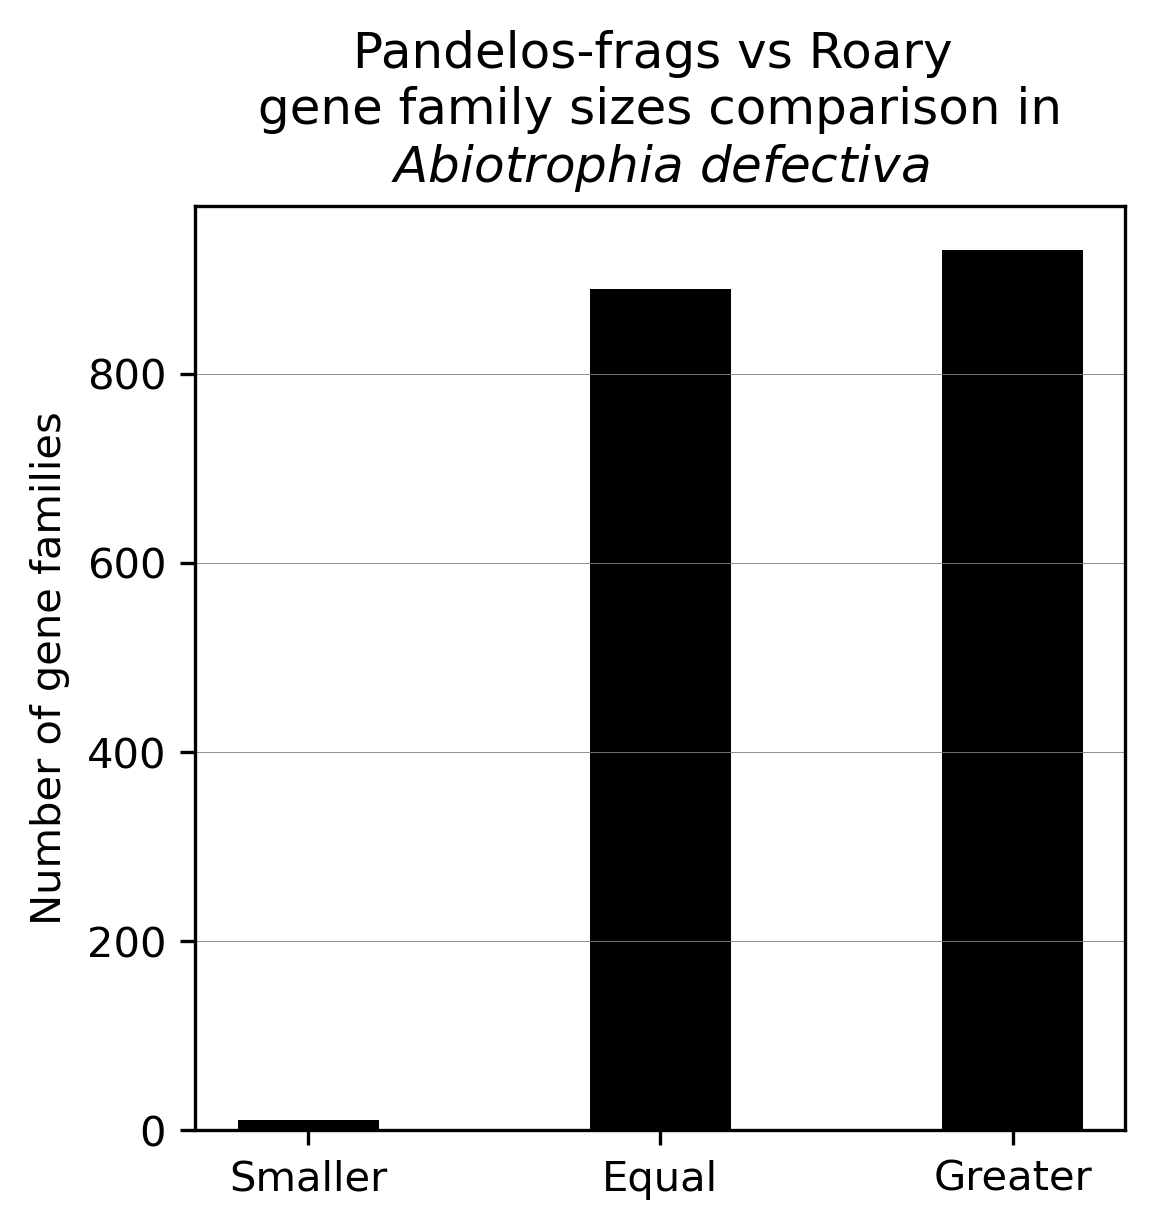

In [16]:
fig, axe = plt.subplots(figsize=(4,4), dpi=300)

c=Counter(compare_mapping_genes['Flag'])
print(c)
print([(int(c[x])/len(compare_mapping_genes))*100 for x in c])
plt.ylabel('Number of gene families')
plt.title('Pandelos-frags vs Roary \n gene family sizes comparison in \n'+pretty_species)
plt.bar(['<','=','>'],[c[k] for k in ['<','=','>']],color='black',width=0.4) 
plt.grid(True, axis='y', color = "grey", linewidth = "0.2")
plt.xticks(range(0,3),labels=['Smaller', 'Equal','Greater'],fontsize=10)
plt.show()
##plt.savefig(figdir+'/'+species+'_size.svg', dpi=300)


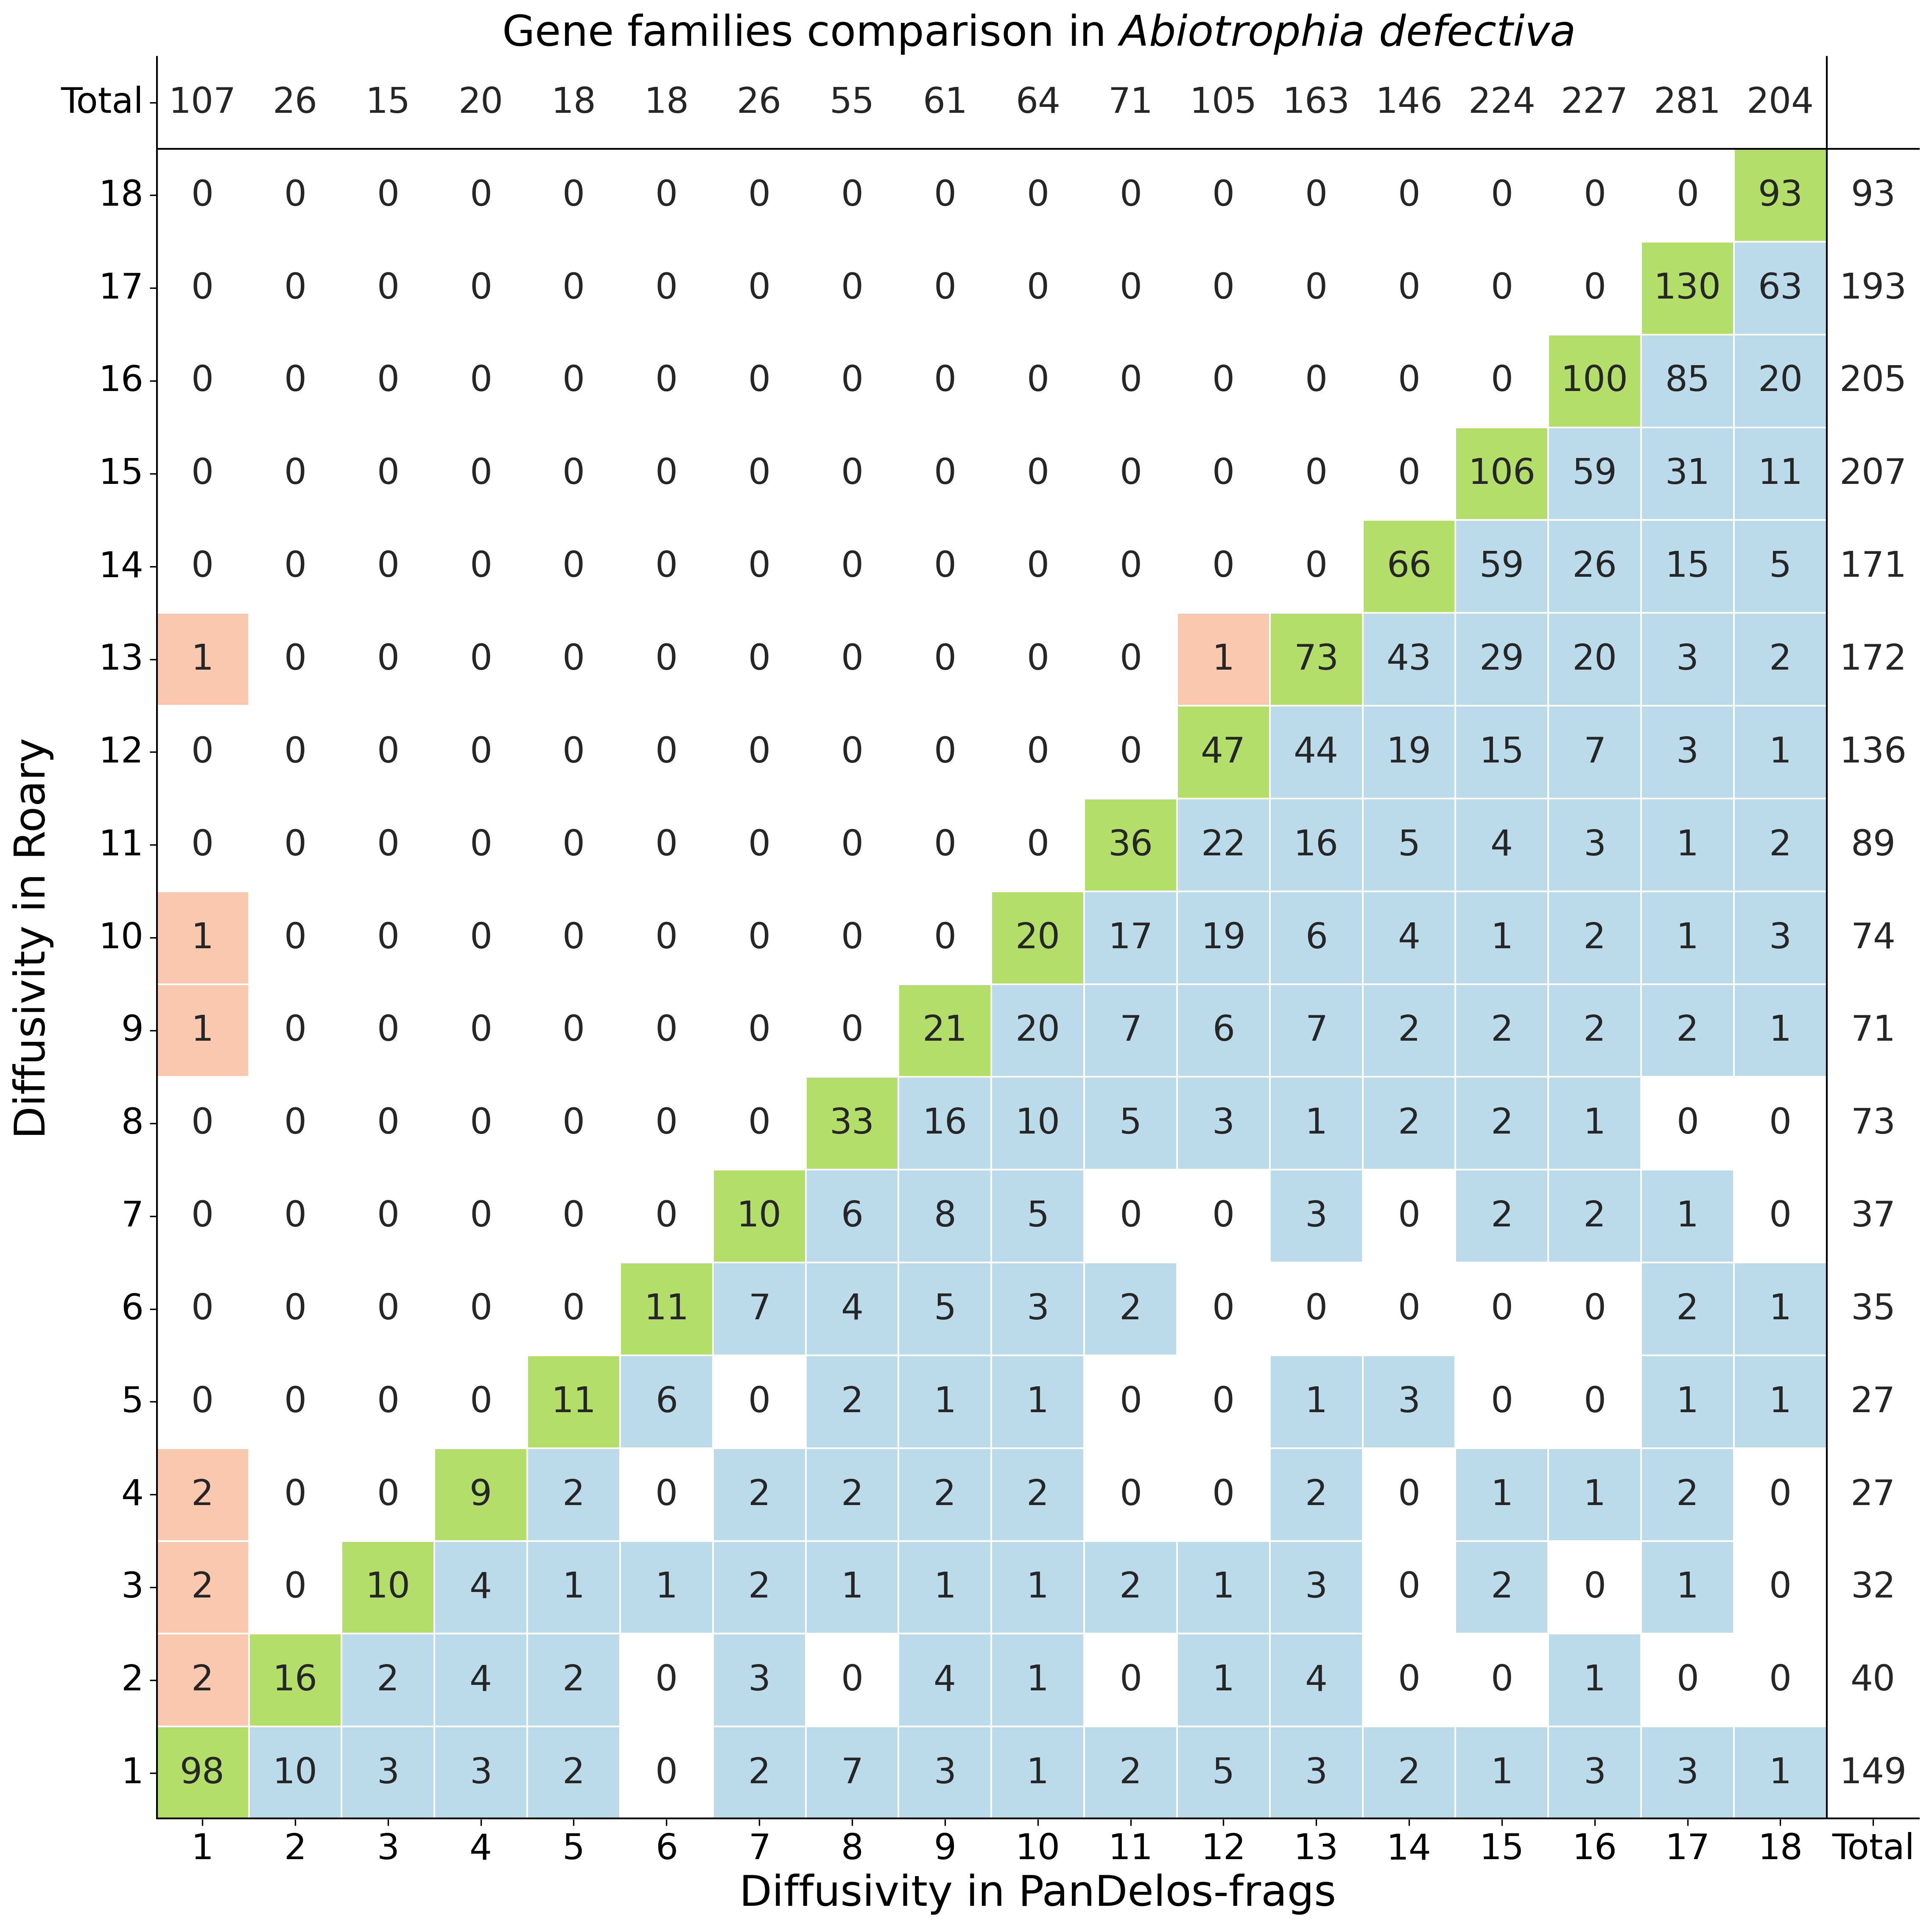

In [20]:
# Heatmap preparation
compare_mapping_genes['value']=1
compare_mapping_genes_stratify = compare_mapping_genes.pivot_table(columns='GF_size_Roary',index='GF_size_pandelos',values='value',aggfunc='sum').fillna(0)
compare_mapping_genes_stratify_T = compare_mapping_genes_stratify.T

#add marginal sums
compare_mapping_genes_stratify_T['Total'] = compare_mapping_genes_stratify_T.sum(axis=1)


#add marginalized and revert roary order
marginal=compare_mapping_genes_stratify_T.sum(axis=0)
marginal.name='Total'
compare_mapping_genes_stratify_T=compare_mapping_genes_stratify_T.append(marginal,ignore_index=False)
compare_mapping_genes_stratify_T=compare_mapping_genes_stratify_T.reindex(['Total']+list(reversed(range(1,len(names_df)+1))))

compare_mapping_genes_stratify_discrete = compare_mapping_genes_stratify_T.copy()

for i in compare_mapping_genes_stratify_T.index:
    for j in compare_mapping_genes_stratify_T.columns:
        if i == 'Total' or j == 'Total' or compare_mapping_genes_stratify_T.loc[i,j] == 0.0:
            compare_mapping_genes_stratify_discrete.loc[i,j] = 0
        elif i == j:
            compare_mapping_genes_stratify_discrete.loc[i,j] = 3
        elif i < j:
            compare_mapping_genes_stratify_discrete.loc[i,j] = 2
        else:
            compare_mapping_genes_stratify_discrete.loc[i,j] = 1

compare_mapping_genes_stratify_discrete['Total']['Total'] = 4
fig = plt.figure(figsize=(len(names_df),len(names_df))) 
ax = plt.axes()

qualitative_colors = sns.color_palette("Set3", 10)
other_pal=sns.color_palette("RdBu", 10)
pastels=[other_pal[3],other_pal[6],qualitative_colors[6]]
l=['white']
for x in pastels:
    l.append(x)
cmaps=ListedColormap(l)

ax = sns.heatmap(compare_mapping_genes_stratify_discrete,mask=compare_mapping_genes_stratify_discrete!=4, annot=False, annot_kws={"fontsize":20,"color":"white"}, square=True,  cbar=False, cmap=ListedColormap(['white']),linewidth=0.5,ax=ax,linecolor='white')
ax = sns.heatmap(compare_mapping_genes_stratify_discrete, mask=compare_mapping_genes_stratify_discrete==4, linewidth = 0.5, linecolor='white' , annot = compare_mapping_genes_stratify_T.astype(int), annot_kws={"size":20},cmap=cmaps, cbar=False, fmt="d",square=True,ax=ax)


plt.yticks(rotation=0,fontsize=20)
plt.xticks(rotation=0,fontsize=20)
plt.ylabel('Diffusivity in Roary',fontsize=24)
plt.xlabel('Diffusivity in PanDelos-frags',fontsize=24)
plt.title('Gene families comparison in '+pretty_species,fontsize=24)

ax.axhline(y=1, color='k',linewidth=1)
ax.axhline(y=len(names_df)+1, color='k',linewidth=2)
ax.axvline(x=0, color='k',linewidth=2)
ax.axvline(x=len(names_df), color='k',linewidth=1)
#plt.savefig(figdir+'/'+species+'_HEATMAP.svg', dpi=300,bbox_inches='tight')
plt.show()

# Functional analysis preparation

Prepare for Diamond blastX: 
For each GF where one tool is greater than the other, check the genes that correspond across tools in the same GF and the ones that don't. For all of them run blastx. 
Steps:
1) create fasta files, ones for each GF
2) read them and map with blastx
3) split into mapping and mapping

In [188]:
compare_mapping_genes

,gene,GF_size_pandelos,GF_size_Roary,Flag,value
0,group_319,11,9,>,1
1,group_273,28,26,>,1
2,group_5070,28,7,>,1
3,group_2308,19,8,>,1
4,group_3038,22,18,>,1
...,...,...,...,...,...
4330,group_4273,24,17,>,1
4331,group_6097,22,17,>,1
4332,group_6260,21,10,>,1
4333,group_3941,24,18,>,1


### GFs greater in PanDelos-frags than in Roary

In [189]:
# detect genes of interest
genes_pandelos_1 = np.array(compare_mapping_genes[(compare_mapping_genes['Flag'] == '>')]['gene']) 
# dictionary mapping pandelos gene as specific/unspecific
pandelos_specific = dict()
for g in genes_pandelos_1 :
    pandelos_genomes_in_g = [f.split(':')[0] for f in joined[joined['Gene']==g]['Family'].values[0]]
    pandelos_genes_in_g = [f for f in joined[joined['Gene']==g]['Family'].values[0]]
    roary_genomes_in_g = [f.split('_')[0] for f in joined[joined['Gene']==g]['Family_b'].values[0]]
    roary_genomes_in_g_pandelostranslated = [names_df[names_df['roary_name']==p]['pandelos_name'].values[0] for p in roary_genomes_in_g]
    dict_add = {pandelos_genes_in_g[i]:not (p in roary_genomes_in_g_pandelostranslated) for i,p in enumerate(pandelos_genomes_in_g)}
    pandelos_specific.update(dict_add)

In [190]:
# get fasta
df_pandelos_1 = joined[joined['Gene'].isin(genes_pandelos_1)]
frag_dir = delosdir+'/output/fragmented_coordinates/'
records_pan = {}
for d in os.listdir(frag_dir):
    with open(frag_dir+d+'/'+"coordinates_frag.sam") as f:
        lines = f.readlines()
        for l in lines:
            if l.startswith('@'):
                continue
            l = l.split('\t')
            name = l[0]
            seq = l[9]
            records_pan[name] = seq

# also for reference genes
ref_pandelos= {}
with open(delosdir+'/output/complete/'+ref_genome+'/gene_sequences.fna') as ref_file: 
    lines = ref_file.readlines()
    for l in lines:
        if l.startswith('>'):
            name = l.split('\t')[1]
        else:
            seq = l.strip()
        
        ref_pandelos[name] = seq
records_pan.update(ref_pandelos)

#write down GFs to a file each
for r in df_pandelos_1.index:
    gene = df_pandelos_1.loc[r,'Gene']
    #ID = df_pandelos_1.loc[r,'ID']
    genome_with_families = df_pandelos_1.loc[r,'Family'] 

    with open(GF_dir+'/fasta/'+gene+'.fa','w') as f:
        for g in genome_with_families:
            if g in pandelos_specific:
                if pandelos_specific[g]:
                    g_lab = g +'_PANSPECIFIC'
                else:
                    g_lab = g +'_GENERAL'
                f.write('>'+g_lab+'\n')
                f.write(str(records_pan[g])+'\n')

In [191]:
import subprocess
faa_reference = prokkadir+'/prokka_'+ref_genome+'/*.faa'
ret=subprocess.call(['bash',basedir+"/analysis_scripts/run_diamond.sh",species,faa_reference],stdout=subprocess.DEVNULL)

In [192]:
# Read in the results
files=os.listdir(diamond_directory)

count = 0
empty = 0
div = 0
df_gfs_l = []
for f in files:
    delos2uniprot = dict()
    delos2scores = dict()
    
    try:
        pandas_df = pd.read_csv(diamond_directory+f,sep='\t',header=None)
    except:
        empty += 1
        df_gfs_l.append({'GFs':f.split('.')[0],
                     'mapping_Dim':0,
                     'Pan':0,
                     'Pan_prots':0,
                     'Pan_prot':0,
                     'Gen':0,
                     'Gen_prots':0,
                     'Gen_prot':0,
                     'Same':False})
        continue
    
    set_genes = set()
    for r in pandas_df.index:
        pandelos_gene = pandas_df.iloc[r,0]
        set_genes.add(pandelos_gene)
        uniprot_gene = pandas_df.iloc[r,1]

        score = pandas_df.iloc[r,2]
        if pandelos_gene in delos2scores:
            if delos2scores[pandelos_gene] > score:
                continue
            else:
                delos2scores[pandelos_gene] = score
                delos2uniprot[pandelos_gene] = uniprot_gene
        else:
            delos2uniprot[pandelos_gene] = uniprot_gene
            delos2scores[pandelos_gene] = score
            
    missing_map = set_genes - set(delos2uniprot.keys()) 
    if len(missing_map) >0 :
        print('missing: ',missing_map)
    
    r = re.compile(".*PANSPECIFIC")
    matching_gene = list(filter(r.match, delos2uniprot.keys()))
    panspecific_uniprot = [delos2uniprot[u] for u in matching_gene]
 
    r = re.compile(".*GENERAL")
    unmatching_gene = list(filter(r.match, delos2uniprot.keys()))
    general_uniprot = [delos2uniprot[u] for u in unmatching_gene]
    
    if len(general_uniprot) > 0:
        max_gen = max(Counter(general_uniprot))
    else:
        max_gen = 0
    if len(panspecific_uniprot) > 0:
        max_pan = max(Counter(panspecific_uniprot))
    else:
        max_pan = 0 
     
    flag = max_pan == max_gen
    if flag:
        count += 1
    else:         
        div += 1
        
    df_gfs_l.append({'GFs':f.split('.')[0],
                     'mapping_Dim':len(set_genes),
                     'Pan':len(panspecific_uniprot),
                     'Pan_prots':panspecific_uniprot,
                     'Pan_prot':max_pan,
                     'Gen':len(general_uniprot),
                     'Gen_prots':general_uniprot,
                     'Gen_prot':max_gen,
                     'Same':flag})

fun_greater=pd.DataFrame(df_gfs_l)

print('Matching function:',count)
print('Unmatching function:', div)
print('Protein unmapped:', empty)

matching = (count*100)/(div+empty+count)
other=((div+empty)*100)/(div+empty+count)
print('Percentage Matching:',matching)
print('Percentage Other:', other)

Matching function: 2202
Unmatching function: 237
Protein unmapped: 0
Percentage Matching: 90.28290282902829
Percentage Other: 9.71709717097171


### GFs greater in Roary than in PanDelos-frags

In [194]:
#detect gens of interest
genes_roary = np.array(compare_mapping_genes[(compare_mapping_genes['Flag'] == '<')]['gene']) 
# dictionary mapping roary genes as specific/unspecific
roary_specific = dict()
for g in genes_roary :
    roary_genomes_in_g = [f.split('_')[0] for f in joined[joined['Gene']==g]['Family_b'].values[0]]
    roary_genes_in_g = [f for f in joined[joined['Gene']==g]['Family_b'].values[0]]
    pandelos_genomes_in_g = [f.split(':')[0] for f in joined[joined['Gene']==g]['Family'].values[0]]
    pandelos_genomes_in_g_roarytranslated = [names_df[names_df['pandelos_name']==p]['roary_name'].values[0] for p in pandelos_genomes_in_g]
    dict_add = {roary_genes_in_g[i]:not (p in pandelos_genomes_in_g_roarytranslated) for i,p in enumerate(roary_genomes_in_g)}
    roary_specific.update(dict_add)

In [195]:
# Read in annotations
gene2function = dict()

for f in os.listdir(prokkadir+'/prokka_gffs'):
    with open(prokkadir+'/prokka_gffs/'+f,'r') as file:
        lines = file.readlines()
        for l in lines:
            if l.startswith('#'):
                continue
            elif l.startswith('>'):
                break
            else:
                l = l.split('\t')[8]
                l = l.split(';')
                if l[0].startswith('ID'):
                    ID = l[0].split('=')[1]
                    product = [single for single in l if single.startswith('product')]
                    if len(product)>0:
                        product = product[0].split('=')[1]
                    else:
                        product='empty'

                    gene2function[ID]=product.rstrip()

prokka_BackhedF_2015__SID179_4M__bin.23.fa.gff
prokka_XieH_2016__YSZC12003_37322__bin.23.fa.gff
prokka_LeChatelierE_2013__MH0274__bin.42.fa.gff
prokka_HMP_2012__SRS016095__bin.41.fa.gff
prokka_YuJ_2015__SZAXPI015232-18__bin.18.fa.gff
prokka_QinN_2014__LD-24__bin.22.fa.gff
prokka_XieH_2016__YSZC12003_36057__bin.83.fa.gff
prokka_Bengtsson-PalmeJ_2015__TRAVELRES52__bin.52.fa.gff
prokka_BackhedF_2015__SID203_B__bin.4.fa.gff
prokka_HeQ_2017__SZAXPI029486-84__bin.10.fa.gff
prokka_CosteaPI_2017__daisy-11-388-0__bin.53.fa.gff
prokka_Bengtsson-PalmeJ_2015__TRAVELRES54__bin.8.fa.gff
prokka_GCF_019930665.1_ASM1993066v1_genomic.fna.gff
prokka_LeChatelierE_2013__MH0239__bin.61.fa.gff
prokka_CosteaPI_2017__alien-11-881-0__bin.18.fa.gff
prokka_ZellerG_2014__CCIS33816588ST-4-0__bin.69.fa.gff
prokka_GeversD_2014__SKBSTL034__bin.76.fa.gff
prokka_CosteaPI_2017__alien-11-918-0__bin.21.fa.gff
prokka_CosteaPI_2017__daisy-11-392-0__bin.21.fa.gff
prokka_BackhedF_2015__SID511_4M__bin.19.fa.gff
prokka_BackhedF_

In [196]:
# Extract results
equal = 0
diff = 0
gene2equal = dict()
for genes in genes_roary:
    fam = joined.loc[joined['Gene']==genes,'Family_b'].values[0]
    roary_funs = []
    generic_funs=[]

    for g in fam:
        f = gene2function[g]
        if roary_specific[g]==True:
            roary_funs.append(f)
        else:
            generic_funs.append(f)

    max_roa = max(Counter(roary_funs))
    max_gen = max(Counter(generic_funs))

    if max_roa == max_gen:
        equal +=1
        gene2equal[genes]='Green'
    else:
        print(max_roa)
        print(max_gen)
        diff +=1
        gene2equal[genes]='Red'
        
equal_p = equal/(equal+diff)
diff_p=diff/(equal+diff)
print('Matching:',equal_p)
print('Other:',diff_p)

TonB-dependent receptor P3
hypothetical protein
hypothetical protein
N-acetyl-alpha-D-glucosaminyl-diphospho-ditrans%2Coctacis-undecaprenol 4-epimerase
Glucose-1-phosphate thymidylyltransferase 2
Glucose-1-phosphate thymidylyltransferase
hypothetical protein
Transcription antitermination protein RfaH
Multidrug resistance protein MdtH
hypothetical protein
Efflux pump periplasmic linker BepF
Solvent efflux pump periplasmic linker SrpA
